# Project 1: Trading with Momentum

We start by importing the required packages.

In [697]:
import numpy as np #The Numpy numerical computing library
import pandas as pd #The Pandas data science library
import requests #The requests library for HTTP requests in Python
import xlsxwriter #The XlsxWriter libarary for 
import math #The Python math module
from scipy import stats #The SciPy stats module
from statistics import mean #To calculate the arithmetic mean
import matplotlib.pyplot as plt #To graph certain quantities
%matplotlib inline 
#To ensure the plots are embedded inside the notebook
import time #For a delay loop to run several API calls
import decimal # To tackle floating point rounding errors

## Load Data:

Now we don't have the data provided by udacity so we'll make do with free data that we can find. We will need the list of tickers that we need for the API call. I'm not using our previous set of tickers as that set is 2 years old. So, I downloaded a new list of updated tickers of the S&P 500.

We will now read our data into the pandas data frame.

In [667]:
stocks = pd.read_csv('constituents.csv')
stocks

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care
503,ZION,Zions Bancorp,Financials


We found a few tickers for which either no data was available or too little of it was. So we'll remove those from the ticker list.

In [668]:
stocks = stocks[~stocks['Symbol'].isin(['ANTM', 'BLL', 'BF.B', 'FB', 'WLTW'])] #to get rid of the stocks with no data
stocks = stocks[~stocks['Symbol'].isin(['VTRS', 'LIN', 'MRNA', 'OGN', 'OTIS'])] #to get rid of the stocks with too little data
stocks = stocks['Symbol']
stocks 

0       MMM
1       AOS
2       ABT
3      ABBV
4      ABMD
       ... 
500     YUM
501    ZBRA
502     ZBH
503    ZION
504     ZTS
Name: Symbol, Length: 495, dtype: object

We will deal with any None or NaN values that arise later on.

Next we will import our API token in order to make our API call.

In [ ]:
from secrets_alpha import ALPHA_API_TOKEN as API_TOKEN

We can now proceed to testing our API call.

## Making our Test API Call:

We are well familiar with the process of API calling by now. But it is good practice to make a single API call to test run the code and its performance. We can then reuse the same code to make our batch API calls. Now it's time to structure our API calls. We need the following information from the API:
- Month-end prices

After a bit of looking through, we have found the Alpha Vantage API which has a monthly adjusted time series end point. This will be perfect for our use. Creating an API URL was pretty straight forward with this one.

In [145]:
symbol_1 = 'AAPL'
api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol_1}&apikey={API_TOKEN}'
data = requests.get(api_url) # To get the data we need
data.status_code # To check the response code

200

That's works! Let's see the data.

In [ ]:
data = data.json() # To convert the data into a .json dictionary for easier handling
data

We can see that the data is pretty extensive. Given the project from udacity we need to build a trading signal based on month end prices. We'll fill in the data for month end prices of the past 5 years. I am removing the output for this one. As it was too long to be presentable.

## A Side Project on Apple Stock Prices:

How about before proceeding as a side project we plot the month end price of Apple stock for 5 years. We start by creating a new data frame.

In [70]:
my_columns = ['Date', 'Adjusted Close Price']
test_dataframe = pd.DataFrame(columns = my_columns)
test_dataframe

,Date,Adjusted Close Price


Now we'll push the data into this data frame.

In [71]:
key_sample = list(data['Monthly Adjusted Time Series'])
for key in key_sample[1:121]: # The range represents past 10 years of data that we need
    test_dataframe.loc[key_sample.index(key), 'Date'] = key
    test_dataframe.loc[key_sample.index(key), 'Adjusted Close Price'] = np.float(data['Monthly Adjusted Time Series'][key]['5. adjusted close'])
test_dataframe

,Date,Adjusted Close Price
1,2022-07-29,162.51
2,2022-06-30,136.72
3,2022-05-31,148.84
4,2022-04-29,157.42
5,2022-03-31,174.355
...,...,...
116,2012-12-31,16.3956
117,2012-11-30,18.0317
118,2012-10-31,18.2544
119,2012-09-28,20.4555


We'll sort the value inside the data frame before we proceed to plot it.

In [73]:
test_dataframe = test_dataframe.sort_values(by='Date')
test_dataframe

,Date,Adjusted Close Price
120,2012-08-31,20.3983
119,2012-09-28,20.4555
118,2012-10-31,18.2544
117,2012-11-30,18.0317
116,2012-12-31,16.3956
...,...,...
5,2022-03-31,174.355
4,2022-04-29,157.42
3,2022-05-31,148.84
2,2022-06-30,136.72


We'll set the index to a DateTime index so that it's easier to the graph the data.

In [87]:
test_dataframe = test_dataframe.set_index('Date', drop=True, inplace=True) # takes column 'Date' and makes it an inplace index
test_dataframe.index = pd.to_datetime(test_dataframe.index) # converts the index to DateTimeIndex

Now let's plot the data. 

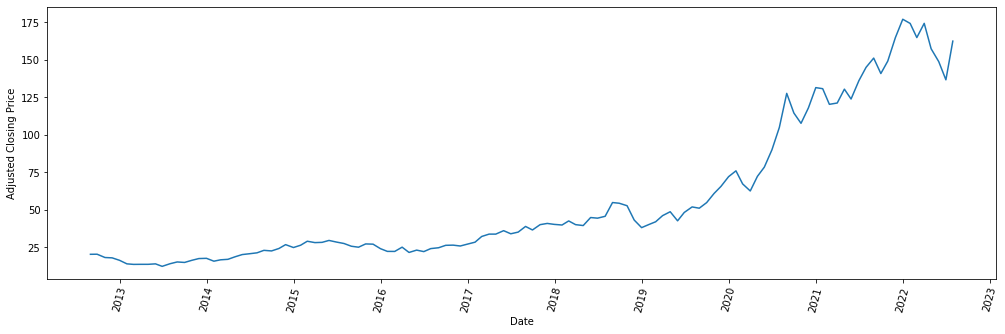

In [95]:
fig, ax = plt.subplots()
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.plot(test_dataframe.index, test_dataframe['Adjusted Close Price'])
plt.xticks(rotation = 75)
fig.set_figwidth(17)
fig.set_figheight(5)
plt.show()

I did this to give me a rough idea of whether or not the data I have matches with reality. Comparing with the real stock price graph of Apple in the last 10 years one can tell quite easily that the dataset I have is a fairly reasonable approximation.

## Why not resample data?

I didn't use the resample() function as I don't have the dataset provided by Udacity. And filing in all the prices for each trading day in the last five years to eventually resample them was a cumbersome task. So instead I'd make a data frame with only the month end prices for each Ticker for the last 5 years.

After a lot of searching and trying different API's out, I stumbled upon the AlphaVantage API, that was willing to provide me with adjusted prices, of the last 20 years, free of cost.

## Making our API Call:

This time we wouldn't be making any batch API calls. As I couldn't find an API to get the required metric which also supports batch API calls. So we'll stick to single API calls which are slow granted but will do the job here as the data is not that volumous.

We start with the first ticker and then we'll append each column of data, correspondng to the ticker, on to our data frame. I am creating a massive data frame that will contain the month end prices for all the tickers in the S&P 500, for the last 5 years. 

In [695]:
my_columns = ['DATE', 'MMM']
test_dataframe = pd.DataFrame(columns = my_columns)
test_dataframe

,DATE,MMM


In [696]:
symbol = 'MMM'
api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol}&apikey={API_TOKEN}'
data = requests.get(api_url).json()
key_sample = list(data['Monthly Adjusted Time Series'])
for key in key_sample[1:61]: # range represents past 5 years of data
    test_dataframe.loc[key_sample.index(key), 'DATE'] = key
    test_dataframe.loc[key_sample.index(key), 'MMM'] = np.float(data['Monthly Adjusted Time Series'][key]['5. adjusted close'])
test_dataframe.head()

,DATE,MMM
1,2022-07-29,143.24
2,2022-06-30,129.41
3,2022-05-31,149.29
4,2022-04-29,142.773
5,2022-03-31,147.386


In [129]:
test_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 1 to 60
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    60 non-null     object
 1   MMM     60 non-null     object
dtypes: object(2)
memory usage: 2.9+ KB


Now we'll make out API call. We'll call this the final_dataframe. First we copy the test_dataframe on to it.

In [ ]:
final_dataframe = test_dataframe.copy()

Now we'll run the code below. I realised that Alpha Vantage API limits my calls to 5 per minute and 500 per day. So this will take some time. After testing I came up with the approximation of 2 seconds per API call, so I added in a delay of 10 seconds before each consecutive call. This should be enough!

In [486]:
for symbol in stocks:
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol}&apikey={API_TOKEN}'
    data = requests.get(api_url).json()
    key_sample = list(data['Monthly Adjusted Time Series'])
    test_dataframe = pd.DataFrame(columns = [])
    for key in key_sample[1:61]:
        test_dataframe.loc[key_sample.index(key), symbol] = np.float(data['Monthly Adjusted Time Series'][key]['5. adjusted close'])
        final_dataframe[symbol] = test_dataframe.values # we've made sure that the data only has tickers with at least the...
        print(symbol) # past 60 values so we can simply push the column values in the data frame.
    time.sleep(10) # added time delay to fit with API call limit
final_dataframe

,DATE,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,...,WMB,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
1,2022-07-29,143.24,63.2700,108.8400,143.5100,293.01,306.2600,79.9500,82.7700,410.12,...,34.0900,63.4800,73.1800,193.2080,92.0300,122.5400,357.69,110.3900,54.5500,182.5500
2,2022-06-30,129.41,54.4301,108.1691,151.7378,247.51,276.6640,77.8600,77.6000,366.06,...,31.2100,56.9800,70.7600,211.6553,78.1800,113.5100,293.95,105.0600,50.9000,171.5736
3,2022-05-31,149.29,59.8453,116.9401,146.0016,263.70,297.4001,77.8800,90.8200,416.48,...,36.6227,66.1000,74.7866,228.0463,84.2500,121.4700,338.19,119.9456,57.0400,170.6154
4,2022-04-29,142.773,58.1630,112.9976,145.5161,286.58,299.2933,75.6000,89.1576,395.95,...,33.8854,70.4800,72.7219,179.3476,80.2031,116.4464,369.66,120.4844,56.1077,176.9238
5,2022-03-31,147.386,63.3020,117.3744,159.1926,331.24,335.0343,79.6368,89.8545,455.62,...,33.0157,79.7400,71.6399,150.4428,84.9455,117.9590,413.70,127.6187,65.0933,187.9176
6,2022-02-28,147.158,67.9488,119.6155,145.1106,310.74,313.9624,81.0186,78.0975,467.68,...,30.5118,86.5200,66.3700,155.0261,88.6219,121.9895,413.34,122.9790,70.3854,192.9596
7,2022-01-31,162.722,75.7167,126.3986,134.4265,295.87,351.2778,78.5433,74.2720,534.30,...,29.2047,85.4500,68.6667,149.2970,104.2876,123.9947,509.12,118.9470,66.9928,199.0777
8,2021-12-31,174.102,84.7456,139.0639,131.5738,359.17,410.7944,66.1370,66.9340,567.06,...,25.4004,85.0400,66.7347,144.1158,119.0836,137.5561,595.20,122.8339,62.3896,242.7666
9,2021-11-30,166.663,78.0331,124.2722,112.0224,314.78,354.1622,58.2539,61.6062,669.85,...,25.7356,81.0100,62.3910,126.5397,120.2653,121.6866,588.78,115.4235,62.3106,220.8905
10,2021-10-29,173.693,72.1300,127.3550,111.4296,332.04,355.5396,77.7282,63.2639,650.36,...,26.9845,89.8000,63.2329,127.4963,129.3953,123.2810,533.95,138.1222,61.8609,215.0807


In the process of running this code, we found a few tickers that would give out an Error message: 'Invalid API Call'. This could be for various reasons. For example, the stock got relisted or it was removed from the ETF indices list etc. A list of these tickers is ['ANTM', 'BLL', 'BF.B', 'FB', 'WLTW']. We can see that Facebook is on this list. No data is available for it because Facebook changed its name to Meta this June.
We also found a few tickers for which not enough data was available for it to be a part of our dataframe. A list of these tickers is ['VTRS', 'LIN', 'MRNA', 'OGN', 'OTIS']. So I ignored those tickers as well. In order for the code to operate smoothly we'll go back and remove these from the original ticker list.

I can see a few NaN values in a few of the rows. Let's check for them.

In [715]:
final_dataframe.columns[final_dataframe.isnull().any()]

Index(['AMCR', 'CARR', 'CDAY', 'CTVA', 'DISCA', 'DOW', 'EVRG', 'FOXA', 'FOX'], dtype='object')

Since the data contains 60 rows. I have decide that if 54, i.e., 90% of the total data in a column is non null then I'll accept that column into the data frame. Let's drop the rest.

In [716]:
final_dataframe.dropna(axis=1, thresh=54, inplace=True)
final_dataframe.head()

,DATE,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,...,WMB,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
1,2022-07-29,143.24,63.2700,108.8400,143.5100,293.01,306.2600,79.9500,82.7700,410.12,...,34.0900,63.48,73.1800,193.2080,92.0300,122.5400,357.69,110.3900,54.5500,182.5500
2,2022-06-30,129.41,54.4301,108.1691,151.7378,247.51,276.6640,77.8600,77.6000,366.06,...,31.2100,56.98,70.7600,211.6553,78.1800,113.5100,293.95,105.0600,50.9000,171.5736
3,2022-05-31,149.29,59.8453,116.9401,146.0016,263.70,297.4001,77.8800,90.8200,416.48,...,36.6227,66.10,74.7866,228.0463,84.2500,121.4700,338.19,119.9456,57.0400,170.6154
4,2022-04-29,142.773,58.1630,112.9976,145.5161,286.58,299.2933,75.6000,89.1576,395.95,...,33.8854,70.48,72.7219,179.3476,80.2031,116.4464,369.66,120.4844,56.1077,176.9238
5,2022-03-31,147.386,63.3020,117.3744,159.1926,331.24,335.0343,79.6368,89.8545,455.62,...,33.0157,79.74,71.6399,150.4428,84.9455,117.9590,413.70,127.6187,65.0933,187.9176


We have a dataset with 476 columns, i.e., 476 tickers. We'll calculate the log returns for the same.

## Computing Log Returns:

We'll compute log returns ($R_t$) from prices ($P_t$) as your primary momentum indicator:
$$R_t = \log_{e}(P_t) - \log_{e}(P_{t-1})$$
We'll use this form of the formlua because of the difference in computer performance between the basic operators, multiplication and division typically being more expensive.

We check for any zero values.

In [491]:
final_dataframe.values.any()==0

False

Now we need to set a DateTime index for the data. We need this for the shift() function to work.

In [717]:
final_dataframe.set_index('DATE', drop=True, inplace=True)
final_dataframe.index = pd.to_datetime(final_dataframe.index)

In [558]:
final_dataframe.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,WMB,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
DATE,,,,,,,,,,,,,,,,,,,,,
2022-07-29,143.24,63.2700,108.8400,143.5100,293.01,306.2600,79.9500,82.7700,410.12,193.6200,...,34.0900,63.48,73.1800,193.2080,92.0300,122.5400,357.69,110.3900,54.5500,182.5500
2022-06-30,129.41,54.4301,108.1691,151.7378,247.51,276.6640,77.8600,77.6000,366.06,173.0900,...,31.2100,56.98,70.7600,211.6553,78.1800,113.5100,293.95,105.0600,50.9000,171.5736
2022-05-31,149.29,59.8453,116.9401,146.0016,263.70,297.4001,77.8800,90.8200,416.48,188.1542,...,36.6227,66.10,74.7866,228.0463,84.2500,121.4700,338.19,119.9456,57.0400,170.6154
2022-04-29,142.773,58.1630,112.9976,145.5161,286.58,299.2933,75.6000,89.1576,395.95,197.8364,...,33.8854,70.48,72.7219,179.3476,80.2031,116.4464,369.66,120.4844,56.1077,176.9238
2022-03-31,147.386,63.3020,117.3744,159.1926,331.24,335.0343,79.6368,89.8545,455.62,205.1005,...,33.0157,79.74,71.6399,150.4428,84.9455,117.9590,413.70,127.6187,65.0933,187.9176


Now we'll create a function that will take in a data frame containing stock prices and return a data frame with log return calculated.

In [559]:
def calculate_log_returns(prices_dataframe): # returns data frame with log return of a data frame values calculated inplace
    return np.log(prices_dataframe.astype('float'))-np.log((prices_dataframe.astype('float')).shift(-1, axis=0))

In [560]:
log_returns = calculate_log_returns(final_dataframe)
log_returns.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,WMB,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
DATE,,,,,,,,,,,,,,,,,,,,,
2022-07-29,0.101536,0.150494,0.006183,-0.055749,0.168756,0.101631,0.026489,0.064498,0.113653,0.112086,...,0.088266,0.108025,0.033628,-0.091192,0.163101,0.076547,0.196257,0.049488,0.069255,0.062012
2022-06-30,-0.142905,-0.094846,-0.077966,0.038536,-0.063361,-0.072275,-0.000257,-0.157312,-0.129041,-0.083450,...,-0.159930,-0.148468,-0.055345,-0.074590,-0.074775,-0.067776,-0.140198,-0.132507,-0.113890,0.005600
2022-05-31,0.044638,0.028513,0.034295,0.003331,-0.083206,-0.006346,0.029713,0.018474,0.050551,-0.050179,...,0.077684,-0.064160,0.027996,0.240223,0.049226,0.042236,-0.088976,-0.004482,0.016480,-0.036307
2022-04-29,-0.031801,-0.084668,-0.038002,-0.089828,-0.144825,-0.112809,-0.052020,-0.007786,-0.140371,-0.036060,...,0.026001,-0.123442,0.014990,0.175743,-0.057448,-0.012906,-0.112557,-0.057527,-0.148549,-0.060284
2022-03-31,0.001546,-0.070838,-0.018914,0.092619,0.063887,0.064960,-0.017202,0.140234,-0.026125,0.019235,...,0.078870,-0.081604,0.076407,-0.030011,-0.042369,-0.033598,0.000871,0.037033,-0.078164,-0.026477


We'll drop the last row with only NaN values in it before we proceed.

In [561]:
log_returns.drop(axis=0, index=log_returns.index[-1], inplace=True)
log_returns.tail()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,WMB,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
DATE,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0.062300,0.088656,0.090172,0.155871,0.226287,0.048513,0.157619,0.069158,0.130960,0.160023,...,0.029091,-0.017955,-0.052705,-0.016617,0.057827,0.035865,0.171018,0.052072,0.061053,0.064720
2017-12-29,-0.032478,-0.034324,0.012341,-0.002168,-0.038880,0.033746,0.014636,0.005003,-0.034934,-0.012456,...,0.058866,0.064368,-0.062724,-0.036484,-0.016577,-0.022535,-0.060919,0.032001,0.025504,-0.003464
2017-11-30,0.059793,0.068857,0.038703,0.071302,0.009903,0.038921,-0.048333,-0.016342,0.035391,0.211577,...,0.019114,0.072633,0.041340,0.060903,0.044086,0.118129,-0.050119,-0.037873,0.067828,0.126129
2017-10-31,0.092274,-0.001514,0.021004,0.022498,0.134747,0.062198,0.015077,-0.039343,0.160546,-0.193594,...,-0.051629,-0.009649,0.045442,0.086335,0.060408,0.011347,0.066017,0.037958,-0.015378,0.000940
2017-09-29,0.026943,0.064999,0.046414,0.165582,0.111575,0.032429,-0.016146,0.028393,-0.039303,0.013832,...,0.019390,0.069008,-0.037732,-0.015937,0.008982,-0.042683,0.051885,0.026500,0.077537,0.016764


## Generating a Trading Signal:

A trading signal is a sequence of trading actions, or results that can be used to take trading actions. A common form is to produce a "long" and "short" portfolio of stocks on each date (e.g. end of each month, or whatever frequency you desire to trade at). This signal can be interpreted as rebalancing your portfolio on each of those dates, entering long ("buy") and short ("sell") positions as indicated.

Here's a strategy that we will try:

- For each month-end observation period, rank the stocks by previous returns, from the highest to the lowest. Select the top     performing stocks for the long portfolio, and the bottom performing stocks for the short portfolio.

Implement the get_top_n function to get the top performing stock for each month. Get the top performing stocks from prev_returns by assigning them a value of 1. For all other stocks, give them a value of 0. top_n (=10) will have the number of top performing stocks in each row.

In [562]:
top_n = 10

In [563]:
def get_top_n(prev_returns, top_n): # return data frame with top 10 values in each row replaced with 1 while rest are 0
    test_data = prev_returns.copy()
    test_data[:] = 0
    for index, row in prev_returns.iterrows():
        indices_column = row.nlargest(top_n).index
        test_data.loc[index][indices_column] = 1
    return test_data

What we'll do now is sum the values in each column, then sort those values, in descending order based on each column. Then we need the index of the first 10 such columns which we can pass onto a list.

In [564]:
def print_top(dataframe, call, top_n): # prints the top 10 stocks in the data frame
    print('{} most expected {} are:'.format(top_n, call))
    print(', '.join(dataframe.sum().sort_values(ascending=False).index[:10].values.tolist()))

## Viewing the Trading Signal:

What we'll do is sum the values in each column, then sort those values, in descending order based on each column. Then we need the index of the first 10 such columns which we can pass onto a list.

We'll drop the index because DateTimeIndex objects are not iterable.

In [566]:
log_returns.reset_index(drop=True, inplace=True)

First we'll make two copies of the log_returns data frame to pass onto the get_top_n function as it changes the original dataframe.

As long positins are characteristically different from short positions, therefore, we will use 5 year data for our long portfolio but only the past two years for our short portfolio. I have made this decision after playing around with this a lot and analysing the predicted stocks.

Infact I came back and changed it to 6 months for shorting stocks. That seems more reasonable.

In [590]:
final_long = get_top_n(log_returns.copy(), top_n)
final_short = get_top_n(-1*log_returns[0:6].copy(), top_n)
print_top(final_long, 'Longed stocks', top_n)
print_top(final_short, 'Shorted stocks', top_n)

10 most expected Longed stocks are:
ENPH, TSLA, ETSY, TWTR, APA, AMD, DXCM, BBWI, PENN, CZR
10 most expected Shorted stocks are:
IPGP, ALGN, ETSY, PYPL, BBWI, EXPE, NCLH, RCL, CHTR, APA


## Projected Returns:

It's now time to check if your trading signal has the potential to become profitable!

First we'll start by computing the mean of the returns for each month end and then we calculate the net return for the portfolio. We create a function that gives us an array with name of the most longed and short tickers. Then we will creata data frame with the returns of those tickers.

In [569]:
def ticker_array(dataframe): # returns tickers of stocks with max value sum
    return dataframe.sum().sort_values(ascending=False).index[:10].values.tolist()

In [591]:
long_tickers = ticker_array(final_long)
short_tickers = ticker_array(final_short)
print(long_tickers, short_tickers)

['ENPH', 'TSLA', 'ETSY', 'TWTR', 'APA', 'AMD', 'DXCM', 'BBWI', 'PENN', 'CZR'] ['IPGP', 'ALGN', 'ETSY', 'PYPL', 'BBWI', 'EXPE', 'NCLH', 'RCL', 'CHTR', 'APA']


We'll create a function to calculate the mean and round to three decimal places.

In [725]:
def projected_returns(tickers, log_returns): # calculated projected returns
    pj_data = pd.DataFrame(columns = tickers)
    for column in pj_data.columns:
        pj_data[column] = [round(mean(list(log_returns[column].values)), 3)]
    return pj_data

In [726]:
long_data = projected_returns(long_tickers, log_returns)
long_data

,ENPH,TSLA,ETSY,TWTR,APA,AMD,DXCM,BBWI,PENN,CZR
0,0.097,0.043,0.031,0.015,0.001,0.034,0.025,0.006,0.008,0.012


In [595]:
short_data = projected_returns(short_tickers, log_returns[:6])
short_data

,IPGP,ALGN,ETSY,PYPL,BBWI,EXPE,NCLH,RCL,CHTR,APA
0,-0.062,-0.094,-0.069,-0.114,-0.075,-0.091,-0.09,-0.116,-0.053,0.02


## Portfolio Selection:

We can see that there are some stocks that are common between the two portfolios. This means that these stocks have had a lot of volatility in past. We can't have the same stock in both portfolios, for obvious reasons. So let's do a bit of analysis to better select our portfolio to match with the initial assumption, i.e., stocks have a sense of inertia which we call momentum.

We'll start with the common stocks.

In [575]:
long_set, short_set = set(long_data), set(short_data)
print(long_set & short_set)

{'PENN', 'ENPH', 'ETSY'}


Let's plot these to better understand them. We'll need to sort the data frame by the index for this.

In [587]:
final_dataframe.sort_index(inplace=True)

In [711]:
final_dataframe.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,WMB,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
DATE,,,,,,,,,,,,,,,,,,,,,
2017-08-31,175.355,51.2227,46.9227,59.9125,150.80,121.0008,63.5927,35.9587,155.16,93.6765,...,21.8190,130.3518,42.8983,54.9693,58.6551,70.7312,103.09,106.7625,38.5008,60.8392
2017-09-29,180.144,54.6627,49.1519,70.7015,168.60,124.9891,62.5742,36.9943,149.18,94.9812,...,22.2462,139.6647,41.3098,54.1002,59.1843,67.7757,108.58,109.6295,41.6048,61.8677
2017-10-31,197.558,54.5800,50.1952,72.3102,192.92,133.0100,63.5248,35.5671,175.16,78.2638,...,21.1268,138.3236,43.2303,58.9785,62.8697,68.5491,115.99,113.8708,40.9699,61.9259
2017-11-30,209.731,58.4706,52.1760,77.6543,194.84,138.2889,60.5275,34.9906,181.47,96.7047,...,21.5345,148.7443,45.0549,62.6821,65.7034,77.1444,110.32,109.6388,43.8452,70.2505
2017-12-29,203.029,56.4977,52.8239,77.4861,187.41,143.0353,61.4199,35.1661,175.24,95.5076,...,22.8402,158.6336,42.3157,60.4364,64.6232,75.4254,103.80,113.2041,44.9778,70.0076


<AxesSubplot:xlabel='DATE'>

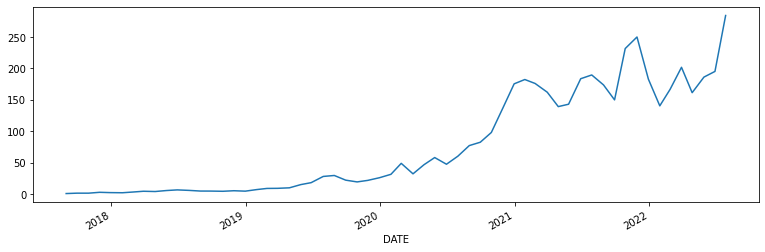

In [722]:
final_dataframe['ENPH'].plot(figsize=(13,4))

We see that this stock has massive movements on both sides which makes it a great pick to be shorted, however, we can also see that it has been consistently growing on average for the past two years. During which time this stock has had massive growth. It shows a mean monthly return percent of 9.7. Upon further research I realised that this company provided dolar power solutions for homes and small industries. Although prone to massive swings, given the current nature of Oil war between Russia and Europe, I think this will be good long term investment. I will go back and change my criteria for shorting stocks based on  6 months history.

In [596]:
long_set, short_set = set(long_data), set(short_data)
print(long_set & short_set)

{'BBWI', 'ETSY', 'APA'}


Now we know that a lot of people are predicting hyper inflation and recession in the coming months this seems like the perfect time to take a short position on a lot of stocks that are actually highly liquid like for example those in the S&P 500. So that's exactly what we'll do 4 stocks for a long position and  stocks for a short position.

I did some some research to find out more about the stocks on the short list and a lot of these have absolutely crashed in the past few months, with a lot of movements and swings. For example let's plot ETSY and BBWI in the past one year.

<AxesSubplot:xlabel='DATE'>

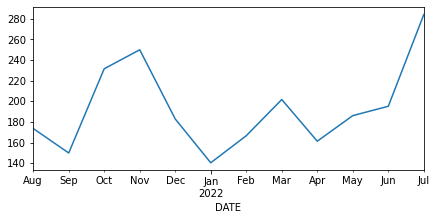

In [629]:
final_dataframe['ENPH'][48:].plot(figsize=(7,3))

<AxesSubplot:xlabel='DATE'>

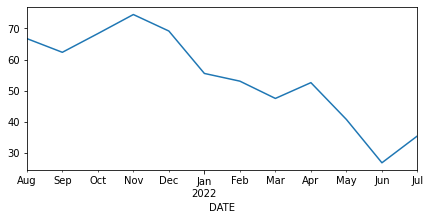

In [630]:
final_dataframe['BBWI'][48:].plot(figsize=(7,3))

This is exactly why we are weighing our portfolio towards shorting more than long term investment. Because in this market it seems like the better strategy, other than being first of course. Have a look at the portfolio.

In [598]:
long_data.drop(labels=['BBWI', 'ETSY', 'APA'], axis=1, inplace=True)
long_position = long_data.iloc[0].nlargest(4).index.values.tolist()
short_position = (-1*short_data).iloc[0].nlargest(6).index.values.tolist()

In [618]:
print('Our Selected Portfolio is:\n Long Position: {}\n Short Position: {}'.format(long_position, short_position))

Our Selected Portfolio is:
 Long Position: ['ENPH', 'TSLA', 'AMD', 'DXCM']
 Short Position: ['RCL', 'PYPL', 'ALGN', 'EXPE', 'NCLH', 'BBWI']


## Average Projected Returns for selected stocks:

We'll now calculate the average returns for our positions.

In [622]:
long_returns = [long_data.loc[0, x] for x in long_position]
short_returns = [short_data.loc[0, x] for x in short_position]
avg_returns = (sum(long_returns) - sum(short_returns))/(len(long_returns)+len(short_returns))
print('The average projected return for the stocks in the portfolio is:\n {}%'.format(round(avg_returns*100, 2)))

The average projected return for the stocks in the portfolio is:
 7.79%


## Projected Portfolio Returns:

The portfolio returns will not simply be equal to the average return as the portfolio is equally weighted by position size, not by the number of shares of each stock. Therefore, the average portfolio return will be the weighted mean of the stock return, weighted by the number of shares of each stock.

Firstly, we'll ask the user for a portfolio size and then calculate portfolio returns based on that.

In [623]:
def portfolio_input():
    global portfolio_size
    portfolio_size = input('Please enter the dollar value of your portfolio:')
    try: 
        val = float(portfolio_size)
    except ValueError: #forcing a string to float() gives a Value Error
        print('Please enter the portfolio value as a number without currency')
        portfolio_size = input('Please enter the dollar value of your portfolio:')
portfolio_input()

Please enter the dollar value of your portfolio: 1000000


Now we'll calculate the projected returns:

In [627]:
position_size = np.float(portfolio_size)/np.float(len(portfolio_stocks))
number_shares = {}
total_return = 0
portfolio_stocks = np.concatenate((long_position, short_position), axis=0)
for stock in portfolio_stocks:
    number_shares[stock] = math.floor(position_size/final_dataframe.loc[final_dataframe.index[-1], stock])
for stock in long_position:
    total_return = total_return + number_shares[stock]*long_data[stock]
for stock in short_position:
    total_return = total_return - number_shares[stock]*short_data[stock]
portfolio_return = total_return/sum(number_shares.values())
print('The projected return on this portfolio is:\n {}% per month'.format(round(portfolio_return[0]*100, 2)))

The projected return on this portfolio is:
 8.54% per month


### Statistical Tests:

### Annualized Rate of Return:

The annualized rate of return allows you to compare the rate of return from this strategy to other quoted rates of return, which are usually quoted on an annual basis

In [626]:
annual_rate = (1+portfolio_return[0])**12 - 1
print('The effective annual rate of return is \n {}%'.format(round(annual_rate*100, 2)))

The effective annual rate of return is 
 167.41%


Well, we would be doubling our money and then some if my strategy is right. That's something, isn't it! I might be a millionaire tomorrow, who knows!

#### A Note on Survivourship Bias and Interpreting the Results:

A monthly portfolio return of ~8.5% is preposterous, for obvious reasons. We are getting this highly optimistic result because of something called survivourship bias. For the long position, we have stocks that are in the S&P 500 which is already an index fund of the most liquid and best performing mega corporations. Which are supposed to be great long term investment. So we're selecting a bunch of great performers from a list of already great performers and expecting them to perform at there best. A smaller subset of the same ETF highly outperforming the ETF itself, is highly unlikely. For our short position, we assume that the crashed stocks will continue to crash at the approximately the same average rate as they have been for the past six months. This can't possibly be true of every stock. We can see that the stock for ETSY is recovering, it may crash again or it may not. We don't know. Same thing can be said about the stock for PayPal. Regardless, of whether they do crash or not, expecting the same average returns to continue for long, especially given the expected recovery after the tumutltuous past two years of COVID, is highly unlikely.

### T-Test:

Our null hypothesis $(H_0)$ is that the actual mean return from the signal is zero. We'll perform a one-sample, one-sided t-test on the observed mean return, to see if we can reject $(H_0)$.

We'll need to first compute the t-statistic, and then find its corresponding p-value. The p-value will indicate the probability of observing a mean return equally or more extreme than the one we observed if the null hypothesis were true. A small p-value means that the chance of observing the mean we observed under the null hypothesis is small, and thus casts doubt on the null hypothesis. It's good practice to set a desired level of significance or alpha $(\alpha)$ before computing the p-value, and then reject the null hypothesis if $p\le{\alpha}$. We'll compute the one-sided $p-$value.

For this project, we'll use $\alpha=0.05$, since it's a common value to use.

In [663]:
from scipy import stats
sample1 = [long_data.loc[0, i] for i in long_position]
sample2 = [-1*short_data.loc[0, i] for i in short_position]
sample_data = np.concatenate((sample1, sample2), axis=0)
t, p = stats.ttest_1samp(sample_data, 0)

In [664]:
p/2 # to get the one sided p-value we divide by 2

1.801458440653797e-05

#### Question: What p-value did you observe? And what does that indicate about your signal?

We get $p\sim10^{-5}$, which implies that $p\le\alpha$, and therefore, we can reject the null hypothesis in this case. We say that the trading signal we have generated is statistically significant and that the mean return is quite unlikely to be zero.

## Conclusions:

This was an absolute nightmare of a project. Not just because every error that could have occurred, did occur! But also because I kept going back rewriting the code again and again to make it more elegant. I started out with the randomised free data from IEX CLoud API. Couldn't figure out how to make batch API calls, so I made do with single API calls. Then I went back to make the batch calls possible. Only to realise that it was only a marginal improvement. With that I noticed that the data was simply too randomised for me to get any thing even remotely significant out of it. So I decided t get real data. I thought momentum trading doesn't usually work anyway but if I am going to do it, then I might as well do it with real data.

So I started out with a search for the APIs that might provide me with the extensive price data the I wanted, along with the speed and the ability to make batch API calls. I stumbled upon AlphaVantage which did the job only to stumble upon Polygon.io which had a better API call limit! Arghhh....
Each peice of code here has been rewritten quite a few times and its still not as elegant as I'd like it to be. I could have used the well crafted packages that the creators at Udacity have gifted mankind. But where's the fun in that. I wouldn't have learned anything much. Anyways, it took me a week to finish a project that I thought would be done in 5 hours. So, that's that!

#### A Note on floating-point representation:

In the quest for making the code as elegant as possible, I stumble upon what's called fixed point aritmetic and why its important. So have a look at this example.

In [689]:
a = 0.1
b = 0.2
a+b

0.30000000000000004

OOPS! What is that? This is rounding error due to our floating point representation which is unable to store numbers <1 precisely. Have a look at the graph bellow where we are graphing the function $$f(x)=\Bigg|\frac{k}{10}-\sum^{k}_{1}{(0.1)}\Bigg|$$

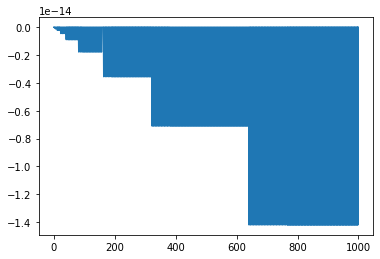

In [690]:
value_graph = [(k/10-k*(0.1)) for k in range(0,1000)]
index_graph = [x for x in range(0,1000)]
plt.plot(index_graph, value_graph)

That should have been a strainght line $x=0$. But it not. The bars implie approximately the same errors for a range of values. This graph also implies that the error increases with the number $k$. Which is obvious as the error gets added with each $k$. This can be solved using the Decimal module in python.

In [693]:
from decimal import Decimal
a = Decimal('0.1')
b = Decimal('0.2')
print(a+b)

0.3


This module takes a string and returns a string. It supports some basic math functions like log, but for more detailed analysis we'll have to covert the string to float to use the math module. That will lead to a loss of precision. However, as far as storing monetary value is concerned Decimal point representation is the way to go in Python. I will be sure to remember this for future projects.

#### A note on Plotly:

I should have used plotly for my graphs to make them more interactive, however, I'd have to restart to kernel for them to work on Jupyter Notebook as I don't have it installed at the moment. That would get rid of all the saved variable which mean I'd have to make the API calls again. That is an exceptionally slow process. So, I will give it a rest this time amd remember to use plotly from the next. That's all I can say after trying to make it work for a couple hours.